In [47]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
from datetime import datetime
from pandas.tseries.offsets import *

from scipy import interpolate
import mplcyberpunk
import matplotlib.pyplot as plt

plt.style.use("cyberpunk")

In [34]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

dataDi = "06/03/2019"

url = f'''
https://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?pagetype=pop&caminho=Resumo%20
Estat%EDstico%20-%20Sistema%20Preg%E3o&Data={dataDi}&Mercadoria=DI1
'''

driver.get(url)

elementoIndice = driver.find_element('xpath', '/html/body/div/div[2]/form[1]/table[3]/tbody/tr[3]/td[1]/table')
elementoTabela = driver.find_element('xpath', '/html/body/div/div[2]/form[1]/table[3]/tbody/tr[3]/td[3]/table')

htmlIndice = elementoIndice.get_attribute('outerHTML')
htmlTabela = elementoTabela.get_attribute('outerHTML')

indice = pd.read_html(htmlIndice)[0]
tabela = pd.read_html(htmlTabela)[0]

driver.quit()

indice.columns = indice.iloc[0]
indice = indice.drop(0, axis=0)

tabela.columns = tabela.iloc[0]
tabela = tabela.drop(0, axis=0)
tabela = tabela['ÚLT. PREÇO']
tabela.index = indice['VENCTO']
tabela = tabela.astype(int)
tabela = tabela[tabela != 0]
tabela = tabela/1000


In [40]:
legenda = pd.Series(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                    index = ['F', 'G', 'H', 'J', 'K', 'M', 'N', 'Q', 'U', 'V', 'X', 'Z'])

listaDatas = []

for indice in tabela.index:

    letra = indice[0]

    ano = indice[1:3]
    mes = legenda[letra]

    data = f'{mes}-{ano}'
    data = datetime.strptime(data, '%b-%y')

    listaDatas.append(data)

tabela.index = listaDatas

tabela

2019-04-01    6.405
2019-05-01    6.410
2019-06-01    6.429
2019-07-01    6.420
2019-08-01    6.410
2019-09-01    6.430
2019-10-01    6.450
2019-11-01    6.450
2019-12-01    6.455
2020-01-01    6.480
2020-02-01    6.535
2020-03-01    6.540
2020-04-01    6.610
2020-07-01    6.780
2020-10-01    7.010
2021-01-01    7.190
2021-04-01    7.390
2021-07-01    7.560
2021-10-01    7.730
2022-01-01    7.870
2022-04-01    8.010
2022-07-01    8.130
2022-10-01    8.240
2023-01-01    8.340
2023-04-01    8.430
2023-07-01    8.530
2024-01-01    8.680
2024-07-01    8.810
2025-01-01    8.900
2025-07-01    8.980
2026-01-01    9.060
2026-07-01    9.060
2027-01-01    9.220
2028-01-01    9.330
2029-01-01    9.350
Name: ÚLT. PREÇO, dtype: float64

In [61]:
curvaDiasUteis = []

diaAtual = datetime(2019,3,6)

for dia in tabela.index:

    diasUteis = len(pd.date_range(diaAtual, dia, freq=BDay()))
    curvaDiasUteis.append(diasUteis)


taxas = tabela.values
taxas = list(taxas)

diasUteisDaquiParaData = len(pd.date_range(diaAtual, datetime(2025,5,31), freq=BDay()))

diasUteisDaquiParaData

1628

In [58]:
diasNovos = [diasUteisDaquiParaData, 520, 385, 2200]

cubica = interpolate.interp1d(curvaDiasUteis, taxas, kind= 'cubic')
taxaCubica = list(cubica(diasNovos))

taxaCubica

[8.964347913330041, 7.321482679581762, 6.914270584606427, 9.325466815245095]

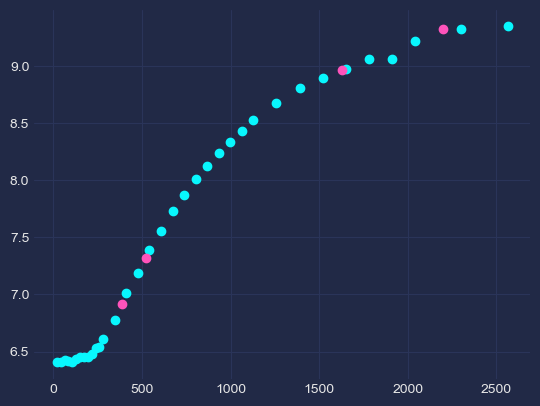

In [60]:
fig, ax = plt.subplots()
ax.scatter(curvaDiasUteis, taxas)
ax.scatter(diasNovos, taxaCubica)